# Diversity Testbench

---
---

## Ember Package

### Setup Dependencies

NOTE: things below this are to install required dependencies (do this in the virtual env)

This may require running these commaned to setup your venv first:
- https://github.com/jaredquincy/ember/blob/main/INSTALLATION_GUIDE.md
- `uv venv`
- `uv pip install ember-ai`
- `uv pip install pip`
- `source .venv/bin/activate`

Plus, add your OpenAI API key -> environ
- `export OPENAI_API_KEY=<key>` in the terminal
- `os.environ["OPENAI_API_KEY"] = <key>` in ipynb cell

In [10]:
import sys, os, logging

In [ ]:
# < enter api keys here! >

In [15]:
openai_key = os.getenv("OPENAI_API_KEY")

# Set global logging level to ERROR
logging.basicConfig(level=logging.ERROR)

os.environ["EMBER_LOGGING_LEVEL"] = "ERROR"

Install dependencies

In [ ]:
# !uv pip install -q -e .

# compression ratio dependencies
!uv pip install diversity==0.2.0
!uv pip install -q spacy==3.8.4

# edit distance
!uv pip install -q python-Levenshtein

# ensemble example
!uv pip install -q matplotlib

Using Python 3.11.9 environment at: /Users/concon/research/ember-branch/ember/.venv
Audited 1 package in 27ms


In [38]:
# basic imports & dependencies
from __future__ import annotations

# class definitions used in ember repo
import math, re, subprocess
from typing import Dict, Any, List, Protocol, TypeVar, Optional, Generic, Callable, Union
from abc import ABC, abstractmethod

# compression related items
from diversity import compression_ratio
import Levenshtein
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

# ember repo loads
from ember.core.registry.model.config.settings import initialize_registry
from ember.core.registry.model.base.services.model_service import ModelService
from ember.core.registry.model.base.schemas.model_info import ModelInfo
from ember.core.registry.model.base.schemas.cost import ModelCost, RateLimit
from ember.core.registry.model.base.schemas.provider_info import ProviderInfo

from ember.core.registry.model import load_model, ChatResponse
from ember.core.registry.model.base.services.model_service import ModelService

from ember.core.registry.model.providers.openai.openai_provider import create_openai_embedding_model
from ember.core.utils.embedding_utils import CosineSimilarity, calculate_text_similarity
from ember.core.utils.eval.diversity_evaluators import DiversityCosineSimilarityEvaluator, DiversityEditDistanceEvaluator, DiversityCompressionEvaluator, DiversityNoveltyEvaluator, DiversityEnsembledEvaluator

Setup model registry to run models

In [18]:
model_registry = initialize_registry()
llm = ModelService(registry=model_registry)

### ModelRegistry checks (**<u>OPTIONAL</u>**)

From the code above, it should auto add models from your config files (which can displayed from printing below), but you can also add your own models as shown below!

In [19]:
model_registry.list_models()

['openai:gpt-4o-audio-preview-2024-12-17',
 'openai:dall-e-3',
 'openai:dall-e-2',
 'openai:gpt-4o-audio-preview-2024-10-01',
 'openai:gpt-4o-realtime-preview-2024-10-01',
 'openai:gpt-4o-transcribe',
 'openai:gpt-4o-mini-transcribe',
 'openai:gpt-4o-realtime-preview',
 'openai:gpt-4o-mini-tts',
 'openai:gpt-4o-realtime-preview-2024-12-17',
 'openai:text-embedding-3-large',
 'openai:gpt-4',
 'openai:text-embedding-ada-002',
 'openai:gpt-4o-mini-audio-preview',
 'openai:gpt-4o-audio-preview',
 'openai:gpt-4o-mini-realtime-preview',
 'openai:gpt-4o-mini-realtime-preview-2024-12-17',
 'openai:gpt-3.5-turbo-instruct-0914',
 'openai:gpt-4o-mini-search-preview',
 'openai:gpt-4-turbo-preview',
 'openai:gpt-4-0125-preview',
 'openai:gpt-3.5-turbo-1106',
 'openai:gpt-4-turbo',
 'openai:gpt-3.5-turbo-instruct',
 'openai:gpt-3.5-turbo',
 'openai:gpt-4o-mini-search-preview-2025-03-11',
 'openai:gpt-4o-2024-11-20',
 'openai:gpt-3.5-turbo-0125',
 'openai:gpt-4o-2024-05-13',
 'openai:gpt-3.5-turbo-16

In [20]:
# Register an OpenAI text-embedding model
try:
    openai_info = ModelInfo(
        id="openai:text-embedding-3-large",
        name="text-embedding-3-large",
        cost=ModelCost(input_cost_per_thousand=0.03, output_cost_per_thousand=0.06),
        rate_limit=RateLimit(tokens_per_minute=80000, requests_per_minute=5000),
        provider=ProviderInfo(name="OpenAI", default_api_key=openai_key),
        api_key=openai_key,
    )
    model_registry.register_model(openai_info)
except ValueError as e:
    print("Error registering model:", e)


Error registering model: Model 'openai:text-embedding-3-large' is already registered.


### Test example of ModelRegistry (**<u>OPTIONAL</u>**)
taken from `src/ember/core/registry/model/examples/example.py`

In [21]:
model_ids: List[str] = [
            "openai:o1",
            "openai:gpt-4o",
            "openai:gpt-4o-mini",
            # "anthropic:claude-3.5-sonnet", # API key not working
            # "invalid:model",  # Expected to trigger an error.
            # "google:model/gemini-1.5-pro", # need to fix model alignment
        ]

In [22]:
for model_id in model_ids:
    try:
        print(f"➡️ Testing model: {model_id}")

        # Two usage styles are demonstrated below:
        # 1. Service-based invocation: Recommended for automatic usage tracking.
        service_response: ChatResponse = llm.invoke_model(
            model_id=model_id,
            prompt="Explain quantum computing in 50 words",
        )
        print(f"🛎️ Service response from {model_id}:\n{service_response.data}\n")

        # 2. Direct model instance usage: Useful for more granular or PyTorch-like workflows.
        model = load_model(model_id=model_id, registry=model_registry)
        direct_response: ChatResponse = model(
            prompt="What's the capital of France?"
        )
        print(f"🎯 Direct response from {model_id}:\n{direct_response.data}\n")

    except Exception as error:
        print(f"❌ Error with model {model_id}: {str(error)}")
        continue


➡️ Testing model: openai:o1
❌ Error with model openai:o1: [Error 3002] Model 'openai:o1' not found. Available models:
- openai:gpt-4o-audio-preview-2024-12-17
- openai:dall-e-3
- openai:dall-e-2
- openai:gpt-4o-audio-preview-2024-10-01
- openai:gpt-4o-realtime-preview-2024-10-01
- openai:gpt-4o-transcribe
- openai:gpt-4o-mini-transcribe
- openai:gpt-4o-realtime-preview
- openai:gpt-4o-mini-tts
- openai:gpt-4o-realtime-preview-2024-12-17
- openai:text-embedding-3-large
- openai:gpt-4
- openai:text-embedding-ada-002
- openai:gpt-4o-mini-audio-preview
- openai:gpt-4o-audio-preview
- openai:gpt-4o-mini-realtime-preview
- openai:gpt-4o-mini-realtime-preview-2024-12-17
- openai:gpt-3.5-turbo-instruct-0914
- openai:gpt-4o-mini-search-preview
- openai:gpt-4-turbo-preview
- openai:gpt-4-0125-preview
- openai:gpt-3.5-turbo-1106
- openai:gpt-4-turbo
- openai:gpt-3.5-turbo-instruct
- openai:gpt-3.5-turbo
- openai:gpt-4o-mini-search-preview-2025-03-11
- openai:gpt-4o-2024-11-20
- openai:gpt-3.5-tur

In [23]:
response = llm(prompt="Hello!", model_id="openai:gpt-4o")
print(response.data)

Hello! How can I assist you today?


---
---

## Diversity Scores

### Neural Similarity Scoring - Cosine Similarity

- from `src/ember/core/utils/embedding_utils.py`

In [24]:
embedding_model = create_openai_embedding_model()
cosine: CosineSimilarity = CosineSimilarity()

text_a: str = "Hello world!"
text_b: str = "Hello, world??"

diverse_text = ["Bananas don't belong in briefcases", "Abraham Lincoln", "ERROR 404: Index Not Found"]

different_words_not_diverse_strs = ["peanut butter and jelly", "bacon lettuce tomato"]

repetition_strs = ["This is a sample text with lots of repetition.", 
                "This is a sample text with lots of repetition."]

test_strings = [diverse_text, different_words_not_diverse_strs, repetition_strs]

for test in test_strings:
    score: float = calculate_text_similarity(
        text1=test[0], text2=test[1], model=embedding_model, metric=cosine
    )

    print(f"Cosine similarity Score: {score:.4f}")
    print("")

Cosine similarity Score: 0.7287

Cosine similarity Score: 0.8205

Cosine similarity Score: 1.0000



### Compression Ratio

- from `src/ember/core/utils/eval/evaluators.py`

In [25]:
compression_evaluator = DiversityCompressionEvaluator()

input_strs = ["hi there", "hi", "hello", "yo whatup"]

# input_strs = ["This is a sample text with lots of repetition.", 
#                 "This is a sample text with lots of repetition.",
#                 "This is a sample text with lots of repetition."]

edit_distance = compression_evaluator.evaluate(input_strs)

print(f"Compression Score: {edit_distance.score:.4f}")
print(f"Is Correct: {edit_distance.is_correct}")
print(f"Metadata: {edit_distance.metadata}")

Compression Score: 0.5766
Is Correct: True
Metadata: {'responses': ['hi there', 'hi', 'hello', 'yo whatup']}


### Edit Distance

In [26]:
distance_evaluator = DiversityEditDistanceEvaluator()

input_strs = ["hi there", "hi", "hello", "yo whatup"]

# input_strs = ["This is a sample text with lots of repetition.", 
#                 "This is a sample text with lots of repetition.",
#                 "This is a sample text with lots of repetition."]

edit_distance = distance_evaluator.evaluate(input_strs)

print(f"Edit Distance Score: {edit_distance.score:.4f}")
print(f"Is Correct: {edit_distance.is_correct}")
print(f"Metadata: {edit_distance.metadata}")

Edit Distance Score: 0.8301
Is Correct: True
Metadata: {'responses': ['hi there', 'hi', 'hello', 'yo whatup']}


### Novelty Score (WIP)

In [27]:
novelty_evaluator = DiversityNoveltyEvaluator(create_openai_embedding_model())

input_strs = ["hi there", "hi", "hello", "yo whatup"]

novelty = novelty_evaluator.evaluate(input_strs)

print(f"Novelty Score: {novelty.score:.4f}")
print(f"Is Correct: {novelty.is_correct}")
print(f"Metadata: {novelty.metadata}")

Novelty Score: 0.3319
Is Correct: True
Metadata: {'responses': ['hi there', 'hi', 'hello', 'yo whatup'], 'novelty_scores': [1.0, 0.11153064719273964, 0.07012108639942194, 0.1458646243357714]}


---
---

## Ensembled Score Example

Function to combine all the scores (cosine similarity, compression ratio, edit distance)

In [28]:
text_embedding_ada_002 = create_openai_embedding_model("text-embedding-ada-002")

cosine_evaluator = DiversityCosineSimilarityEvaluator(embedding_model=text_embedding_ada_002)
compression_evaluator = DiversityCompressionEvaluator()
edit_dist_evaluator = DiversityEditDistanceEvaluator()
diversity_evaluator = DiversityEnsembledEvaluator(embedding_model=embedding_model)

def ensemble_diversity(strings):
    div_cosine = cosine_evaluator.evaluate(strings).score
    div_compression = compression_evaluator.evaluate(strings).score
    div_edit = edit_dist_evaluator.evaluate(strings).score
    div_ensemble_score = diversity_evaluator.evaluate(strings).score
    return div_cosine, div_compression, div_edit, div_ensemble_score

Creating a list of strings

In [29]:
input_strs = []
scores = []
input_strs.append(["This is a sample text with lots of repetition.", 
                "This is a sample text with lots of repetition.",
                "This is a sample text with lots of repetition."])

responses = []
for i in range(10):
    res = llm(prompt="Tell me a funny joke. Keep it concise.", model_id="openai:gpt-4o").data.replace("\n", "")
    responses.append(res)
input_strs.append(responses)

responses = []
res = llm(prompt="Tell me 10 different jokes. make them split with \'||\'. Don't say anything else besides the joke. ", model_id="openai:gpt-4o").data.replace("\n", "").split('||')
responses += res
input_strs.append(responses)

responses = []
res1 = llm(prompt="Tell me a story about how quantum computers work. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res1)
res2 = llm(prompt="Tell me a story about bunnies frolicking in the grass. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res2)
res3 = llm(prompt="Tell me a story about the pokemon pikachu and it's adventures. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res3)
res4 = llm(prompt="Tell me a story about a ramen shop. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res4)
input_strs.append(responses)

input_strs.append([
    "Understanding the importance of effective communication in the workplace cannot be overstated. Clear communication fosters a positive environment where people can express their ideas and work together efficiently. When team members understand one another, they can collaborate seamlessly, avoid misunderstandings, and achieve collective goals. Furthermore, communication skills are essential for building trust, resolving conflicts, and ensuring that expectations are clear. Whether through verbal discussions, emails, or presentations, knowing how to convey thoughts in an understandable way is key to success in any professional setting.",
    "In any workplace, the ability to communicate effectively is crucial for success. When individuals can clearly articulate their ideas and listen actively, it leads to a more productive and harmonious environment. Good communication prevents misunderstandings, aids in team collaboration, and helps in meeting shared objectives. It also plays a vital role in fostering trust among colleagues, resolving disputes, and ensuring transparency. Whether it’s through face-to-face conversations, written messages, or virtual meetings, mastering communication is essential to creating a positive, high-functioning work culture.",
    "Effective communication is a cornerstone of a successful work environment. When employees communicate clearly and efficiently, it improves the overall flow of work and enhances collaboration. Clear exchanges of ideas help to eliminate confusion, build mutual trust, and ensure that everyone is aligned in their goals. Additionally, strong communication skills are key to managing conflicts and setting clear expectations among teams. Whether in meetings, emails, or other formats, being able to communicate effectively contributes to a thriving and efficient workplace.",
    "The role of communication in the workplace cannot be overlooked. It serves as the foundation for successful teamwork and organizational growth. When team members share information clearly, it promotes a collaborative atmosphere and reduces the risk of errors or misinterpretations. Strong communication is also vital in building relationships, resolving issues, and making sure everyone is on the same page. Whether it's verbal exchanges or written correspondence, honing your ability to communicate well is vital for fostering an effective work environment.",
    "Communication within the workplace is a vital element for success. Clear and open communication promotes a cooperative and efficient atmosphere, helping team members to better understand each other’s ideas and work toward common goals. It reduces confusion, builds trust, and allows for smoother problem-solving when conflicts arise. By conveying thoughts and expectations effectively, individuals can create stronger working relationships and a productive team dynamic. Whether through emails, phone calls, or face-to-face interactions, mastering communication techniques is key for professional achievement.",
])

In [30]:
for i in range(len(input_strs)):
    print(f"{i} -------------------")
    for s in input_strs[i]:
        print("\t- " + s)

0 -------------------
	- This is a sample text with lots of repetition.
	- This is a sample text with lots of repetition.
	- This is a sample text with lots of repetition.
1 -------------------
	- Why don't scientists trust atoms?Because they make up everything!
	- Why don't skeletons fight each other? They don't have the guts.
	- Why don't skeletons fight each other? They don't have the guts!
	- Why don't skeletons fight each other? They don't have the guts!
	- Why don't skeletons fight each other? They don't have the guts.
	- Why did the scarecrow win an award? Because he was outstanding in his field!
	- Why do cows have hooves instead of feet?   Because they lactose!
	- Why don't scientists trust atoms?Because they make up everything!
	- Why did the scarecrow win an award? Because he was outstanding in his field!
	- Why don't scientists trust atoms? Because they make up everything!
2 -------------------
	- Why did the scarecrow win an award? Because he was outstanding in his field! 

100%|██████████| 5/5 [02:12<00:00, 26.55s/it]


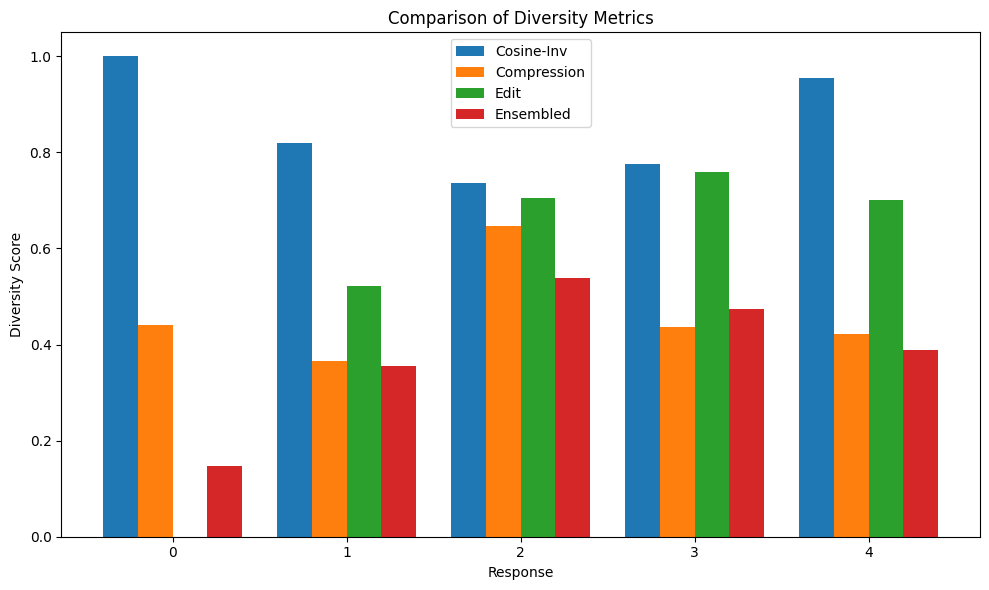

In [37]:
scores = [ensemble_diversity(s_arr) for s_arr in tqdm.tqdm(input_strs)]
labels = [str(number) for number in range(1, len(input_strs) + 1)]

df = pd.DataFrame(
    scores,
    columns=['Cosine-Inv', 'Compression', 'Edit', 'Ensembled']
)

plt.figure(figsize=(10, 6))

x = range(len(df))
width = 0.2

plt.bar([i - width*1.5 for i in x], df['Cosine-Inv'], width=width, label='Cosine-Inv')
plt.bar([i - width*0.5 for i in x], df['Compression'], width=width, label='Compression')
plt.bar([i + width*0.5 for i in x], df['Edit'], width=width, label='Edit')
plt.bar([i + width*1.5 for i in x], df['Ensembled'], width=width, label='Ensembled')

plt.xticks(x, df.index if 'Input' not in df.columns else df['Input'])

plt.xlabel("Response")
plt.ylabel("Diversity Score")
plt.legend()
plt.title("Comparison of Diversity Metrics")
plt.tight_layout()
plt.show()

In this example above:
- 1. Base case of just the same sentence every time
- 2. Asking the LLM 10 times for a joke (with the default temp being low, this should output the same joke most of the time)
- 3. Asking the LLM once for 10 different jokes
- 4. Asking the LLM 4 different times to create a story about 4 random topics (pre-selected)
- 5. Pre-selected LLM call, where it was told to produce 4, ~500 word paragraphs where it explained the exact same thing in a different way


---
---
## Potential Exploration
- work ensembling all "diversity" related metrics 
  - add more metrics
  - tune added metrics
- combination of validation/hallucination metric + ensembled diversity metric -> score